# Quick aws spot prices analysis 

## Import Packages 

In [44]:
import pandas as pd

%pylab inline --no-import
import pylab as pl
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Seaborn options 
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 8)})
plt.style.use('ggplot') # ggplot2 style for matplotlib 


Populating the interactive namespace from numpy and matplotlib


In [2]:
ls

README.md               get_intraday_price.py   myapp.log               spot_price_aws_3.csv
Untitled.ipynb          get_intraday_price.pyc  spot_price_aws.csv      spot_price_aws_wd.csv
get_aws_spotprice.py    logs.json               spot_price_aws.json
get_aws_spotprice.pyc   logs2.json              spot_price_aws_2.csv


In [14]:
df = pd.read_csv('spot_price_aws_wd.csv', parse_dates=["Timestamp"]) # parse dates 

In [34]:
df.shape

(841610, 5)

In [15]:
df.head(5)

,AvailabilityZone,InstanceType,ProductDescription,SpotPrice,Timestamp
0,us-west-1a,m2.4xlarge,Linux/UNIX,0.0698,2016-01-07 11:55:18
1,us-west-1a,c3.2xlarge,Linux/UNIX,0.0891,2016-01-07 11:55:16
2,us-west-1a,c3.2xlarge,Windows,0.2561,2016-01-07 11:55:14
3,us-west-1a,r3.2xlarge,Linux/UNIX,0.0737,2016-01-07 11:55:00
4,us-west-1a,c1.medium,Linux/UNIX,0.0178,2016-01-07 11:54:55


In [22]:
col_category = [u'AvailabilityZone', u'InstanceType', u'ProductDescription']
for col in col_category:
    df.loc[:,col] = df.loc[:,col].astype('category')

In [23]:
df.dtypes

AvailabilityZone            category
InstanceType                category
ProductDescription          category
SpotPrice                    float64
Timestamp             datetime64[ns]
dtype: object

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841610 entries, 0 to 841609
Data columns (total 5 columns):
AvailabilityZone      841610 non-null category
InstanceType          841610 non-null category
ProductDescription    841610 non-null category
SpotPrice             841610 non-null float64
Timestamp             841610 non-null datetime64[ns]
dtypes: category(3), datetime64[ns](1), float64(1)
memory usage: 21.7 MB


In [26]:
df.InstanceType.value_counts()

c3.8xlarge     82919
c3.2xlarge     79663
g2.2xlarge     73940
m3.2xlarge     64869
c3.4xlarge     47763
m3.xlarge      46670
c3.xlarge      39674
r3.2xlarge     35599
c3.large       31043
m2.4xlarge     27402
r3.xlarge      27035
m2.2xlarge     24910
c4.2xlarge     22559
m4.2xlarge     22012
c4.xlarge      20370
r3.large       17162
c4.8xlarge     15377
m4.xlarge      15373
c1.medium      13658
m3.large       13643
c4.large       13272
m2.xlarge      12908
m4.large       12412
r3.4xlarge     10880
c4.4xlarge      9795
r3.8xlarge      9363
g2.8xlarge      8846
m1.large        6227
m1.medium       5679
m4.4xlarge      5369
m3.medium       5350
i2.xlarge       5083
c1.xlarge       4497
t1.micro        2529
m4.10xlarge     2388
m1.xlarge       1798
i2.2xlarge      1362
i2.4xlarge      1146
i2.8xlarge       663
m1.small         402
dtype: int64

In [27]:
df.AvailabilityZone.value_counts()

us-west-1c    465785
us-west-1a    375825
dtype: int64

In [29]:
df.ProductDescription.value_counts()

Linux/UNIX    584794
Windows       178597
SUSE Linux     78219
dtype: int64

## Useful Helpers to plot and understand data

In [ ]:
def select_rp(df, region="us-west-1c",product="Linux/UNIX"):
    """select subset based on region and product"""
    return df.loc[(df.AvailabilityZone==region) & (df.ProductDescription==product),:]

def get_timeserie(instance_type,df=df, region="us-west-1c",product="Linux/UNIX"):
    index = (df.AvailabilityZone == region) & (df.ProductDescription == product) & (df.InstanceType == instance_type)
    val_sp = df.loc[index,"SpotPrice"].values
    index_dates = df.loc[index,'Timestamp']
    return pd.Series(data=val_sp,index=index_dates)

In [105]:
class AwsSpotPrice(object):
    def __init__(self, df):
        """ df is a dataframe with price history"""
        self.df = df
    
    @property
    def instance_types(self):
        """ Return a list of instances types """
        return pd.unique(self.df.InstanceType).tolist()
    
    @property
    def regions(self):
        """ Return a list of regions available"""
        return pd.unique(self.df.AvailabilityZone).tolist()
    
    @property
    def products(self):
        """ Return a list of products available """
        return pd.unique(self.df.ProductDescription).tolist()
    
    @property
    def min_date(self):
        """ Returns start date of the dataframe (min date)"""
        return self.df.Timestamp.min()
    
    @property
    def max_date(self):
        """ Returns end date of the dataframe (max date) """
        return self.df.Timestamp.max()
    
    @property
    def time_delta(self):
        return (self.max_date - self.min_date).days
    
    def get_histo(self, variable_name):
        """ Return a histogram of a variable """
        return df.loc[:,variable_name].value_counts()
    
    def get_timeserie(self,instance_type, start_time=None, end_time=None,
                      region="us-west-1c", product="Linux/UNIX"):
        # Put min_date and max_date as default 
        start_time = self.min_date if start_time is None
        end_time = self.max_date if end_time is None
        # create col boolean
        index = (self.df.AvailabilityZone == region) & (
            self.df.ProductDescription == product) & (self.df.InstanceType == instance_type)
        # complete index with start_date and end_date
        index = index & (df.Timestamp >= start_time) & (df.Timestamp >= end_time)
        val_sp = self.df.loc[index,"SpotPrice"].values
        index_dates = self.df.loc[index,'Timestamp']
        return pd.Series(data=val_sp,index=index_dates)
    
    def plot_timeserie(self, region="us-west-1c", product="Linux/UNIX"):
        return get_timeserie(self, region=region, product=product).plot()
    


NameError: name 'self' is not defined

In [106]:
a = AwsSpotPrice(df)

In [102]:
a.min_date

Timestamp('2015-11-07 12:51:37')

In [103]:
a.max_date

Timestamp('2016-01-07 12:11:34')

In [104]:
a.time_delta

60

In [75]:
a.products

['Linux/UNIX', 'Windows', 'SUSE Linux']

In [76]:
a.regions

['us-west-1a', 'us-west-1c']

In [77]:
a.instance_types

['m2.4xlarge',
 'c3.2xlarge',
 'r3.2xlarge',
 'c1.medium',
 'm2.2xlarge',
 'c3.4xlarge',
 'm4.xlarge',
 'g2.2xlarge',
 'c4.large',
 'm3.xlarge',
 'c3.large',
 'm3.2xlarge',
 'c3.xlarge',
 'c3.8xlarge',
 'm4.large',
 'm3.large',
 'r3.xlarge',
 'r3.large',
 'm4.4xlarge',
 'g2.8xlarge',
 't1.micro',
 'c4.8xlarge',
 'c1.xlarge',
 'm4.2xlarge',
 'r3.4xlarge',
 'r3.8xlarge',
 'm1.medium',
 'm1.large',
 'i2.xlarge',
 'c4.4xlarge',
 'c4.xlarge',
 'i2.8xlarge',
 'm1.xlarge',
 'm2.xlarge',
 'm4.10xlarge',
 'm3.medium',
 'c4.2xlarge',
 'i2.4xlarge',
 'm1.small',
 'i2.2xlarge']

In [78]:
a.get_timeserie('i2.2xlarge')

Timestamp
2016-01-06 19:11:36    0.1880
2016-01-05 19:10:28    0.1880
2016-01-04 19:09:43    0.1880
2016-01-03 19:08:49    0.1880
2016-01-02 19:07:46    0.1880
2016-01-01 19:06:59    0.1880
2015-12-31 19:06:42    0.1880
2015-12-30 19:05:55    0.1880
2015-12-29 19:05:41    0.1880
2015-12-28 19:05:38    0.1880
2015-12-27 19:05:12    0.1880
2015-12-26 19:04:27    0.1880
2015-12-25 19:03:29    0.1880
2015-12-24 19:03:03    0.1880
2015-12-24 19:01:54    0.2650
2015-12-24 18:23:53    0.3212
2015-12-24 18:22:43    0.3187
2015-12-24 18:21:34    0.3415
2015-12-24 18:07:40    0.8692
2015-12-24 18:06:29    0.8694
2015-12-24 18:04:11    0.8692
2015-12-24 18:03:03    0.8694
2015-12-24 18:00:42    0.8692
2015-12-24 17:59:31    0.8694
2015-12-24 17:58:21    0.8692
2015-12-24 17:56:01    0.8694
2015-12-24 17:53:40    0.8692
2015-12-24 17:52:31    0.8694
2015-12-24 17:39:49    0.8692
2015-12-24 17:38:40    0.8694
                        ...  
2015-12-09 20:49:24    0.1880
2015-12-08 20:49:01    0.1880


In [58]:
df.InstanceType.dt

category

In [ ]:
get_instance_types

In [32]:
test = select_rp(df)

In [33]:
test.shape

(317154, 5)

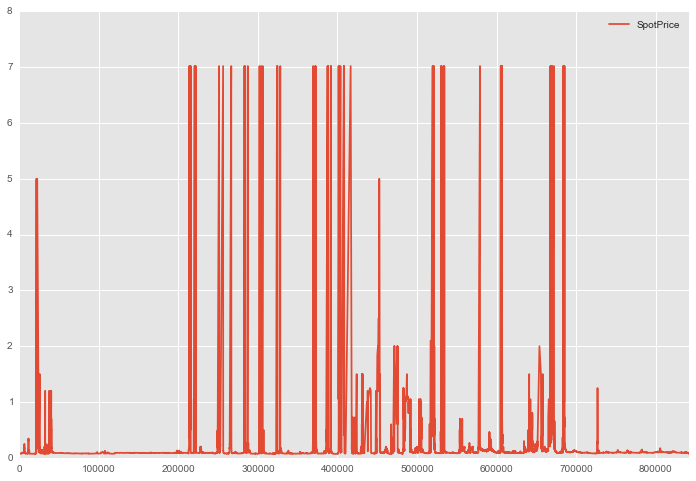

In [45]:
test.loc[test.InstanceType == "g2.2xlarge",:].plot()

In [55]:
s = pd.Series(data=test.loc[test.InstanceType == "g2.2xlarge",'SpotPrice'].values,index=test.loc[test.InstanceType == "g2.2xlarge",'Timestamp'])

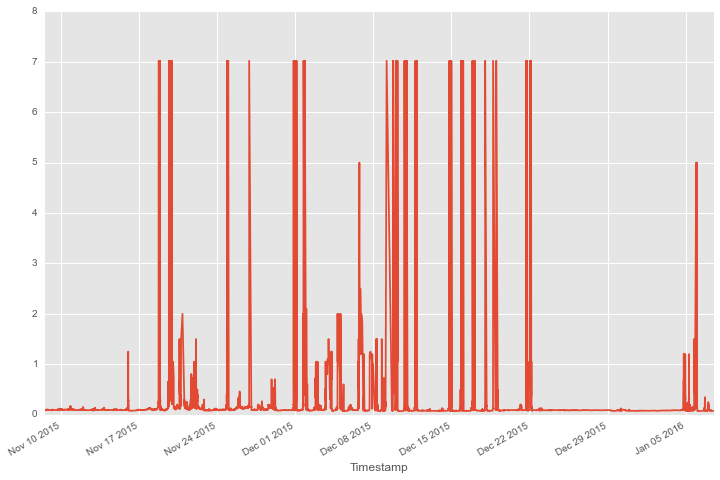

In [56]:
s.plot()

In [53]:
test.loc[test.InstanceType == "g2.2xlarge",'SpotPrice']

21        0.0728
51        0.0735
152       0.0734
181       0.0735
218       0.0736
235       0.0731
285       0.0730
306       0.0731
331       0.0730
355       0.0731
386       0.0732
404       0.0731
465       0.0732
487       0.0733
645       0.0734
890       0.0735
930       0.0734
968       0.0735
1191      0.0734
1204      0.0735
1232      0.0736
1245      0.0735
1257      0.0741
1267      0.0742
1287      0.0741
1303      0.0742
1351      0.0740
1365      0.0741
1446      0.0742
1474      0.0743
           ...  
840557    0.0870
840610    0.0867
840642    0.0869
840690    0.0870
840739    0.0877
840750    0.0867
840766    0.0862
840780    0.0854
840817    0.0853
840832    0.0854
840890    0.0853
840904    0.0854
840952    0.0862
840969    0.0859
840982    0.0856
841022    0.0855
841045    0.0856
841079    0.0858
841092    0.0863
841144    0.0864
841159    0.0856
841205    0.0859
841219    0.0862
841231    0.0861
841242    0.0862
841270    0.0866
841469    0.0728
841507    0.07

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12835d410>]], dtype=object)

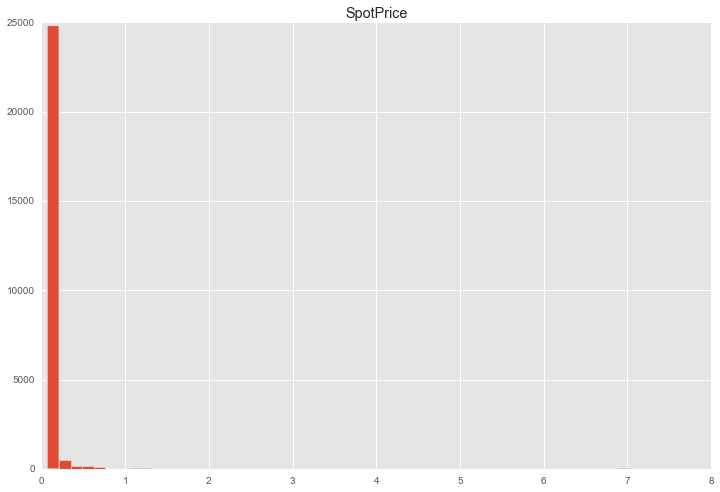

In [46]:
test.loc[test.InstanceType == "g2.2xlarge",:].hist(bins=50)

In [49]:
test.loc[test.InstanceType == "g2.2xlarge",'SpotPrice']

21        0.0728
51        0.0735
152       0.0734
181       0.0735
218       0.0736
235       0.0731
285       0.0730
306       0.0731
331       0.0730
355       0.0731
386       0.0732
404       0.0731
465       0.0732
487       0.0733
645       0.0734
890       0.0735
930       0.0734
968       0.0735
1191      0.0734
1204      0.0735
1232      0.0736
1245      0.0735
1257      0.0741
1267      0.0742
1287      0.0741
1303      0.0742
1351      0.0740
1365      0.0741
1446      0.0742
1474      0.0743
           ...  
840557    0.0870
840610    0.0867
840642    0.0869
840690    0.0870
840739    0.0877
840750    0.0867
840766    0.0862
840780    0.0854
840817    0.0853
840832    0.0854
840890    0.0853
840904    0.0854
840952    0.0862
840969    0.0859
840982    0.0856
841022    0.0855
841045    0.0856
841079    0.0858
841092    0.0863
841144    0.0864
841159    0.0856
841205    0.0859
841219    0.0862
841231    0.0861
841242    0.0862
841270    0.0866
841469    0.0728
841507    0.07

In [41]:
??pd.DataFrame.hist()

In [47]:
test.loc[test.InstanceType == "g2.2xlarge",:].describe()

,SpotPrice
count,25864.000000
mean,0.125235
std,0.347170
min,0.070100
25%,0.080300
50%,0.089300
75%,0.099400
max,7.020000
